# SGG Evaluation Benchmarks

- Recall@50
- Recall@20
- Recall@100
- mR@50
- mR@20
- mR@100

In [2]:
#TODO: Parse input
import json

with open('relationships.json', 'r') as rel_file:
    relationships = json.load(rel_file)

with open('image_data.json', 'r') as img_file:
    image_data = json.load(img_file)

print("Successfully loaded both files!")


Successfully loaded both files!


In [4]:
relationships[0]

{'relationships': [{'predicate': 'ON',
   'object': {'name': 'street',
    'h': 262,
    'object_id': 5046,
    'synsets': ['street.n.01'],
    'w': 714,
    'y': 328,
    'x': 77},
   'relationship_id': 15927,
   'synsets': ['along.r.01'],
   'subject': {'name': 'shade',
    'h': 192,
    'object_id': 5045,
    'synsets': ['shade.n.01'],
    'w': 274,
    'y': 338,
    'x': 119}},
  {'predicate': 'wears',
   'object': {'name': 'sneakers',
    'h': 26,
    'object_id': 5048,
    'synsets': ['gym_shoe.n.01'],
    'w': 52,
    'y': 489,
    'x': 243},
   'relationship_id': 15928,
   'synsets': ['wear.v.01'],
   'subject': {'name': 'man',
    'h': 262,
    'object_id': 1058529,
    'synsets': ['man.n.01'],
    'w': 60,
    'y': 249,
    'x': 238}},
  {'predicate': 'has',
   'object': {'name': 'headlight',
    'h': 15,
    'object_id': 5050,
    'synsets': ['headlight.n.01'],
    'w': 23,
    'y': 366,
    'x': 514},
   'relationship_id': 15929,
   'synsets': ['have.v.01'],
   'subject': {

In [5]:
image_data[0]

{'width': 800,
 'url': 'https://cs.stanford.edu/people/rak248/VG_100K_2/1.jpg',
 'height': 600,
 'image_id': 1,
 'coco_id': None,
 'flickr_id': None}

In [63]:
def recall_at_k(predictions, ground_truths, K) -> float:
    """
    Calculate Recall@K for scene graph evaluation.

    Args:
        predictions (list of list of tuples): A batch of predictions, where each batch contains triplets (subject, predicate, object, score).
        ground_truths (list of list of tuples): A batch of ground truth triplets for each sample.
        K (int): The top-K predictions to consider.

    Returns:
        float: The Recall@K value.
    """
    total_correct = 0
    total_ground_truths = 0

    # Iterate over all samples in the batch
    for pred_sample, gt_sample in zip(predictions, ground_truths):
        # Sort predictions by score and take top-K
        sorted_preds = sorted(pred_sample, key=lambda x: x[3], reverse=True)[:K]
        top_k_preds = {(sub, pred, obj) for sub, pred, obj, _ in sorted_preds}

        # Count matches
        total_correct += sum(1 for triplet in gt_sample if triplet in top_k_preds)
        total_ground_truths += len(gt_sample)

    # Calculate recall
    if total_ground_truths == 0:
        return 0.0

    recall = total_correct / total_ground_truths
    return recall



def mean_recall_at_k(predictions, ground_truths, K) -> float:
    """
    Calculate mean Recall@K (mR@K) for scene graph evaluation.

    Args:
        predictions (list of list of tuples): A batch of predictions, where each batch contains triplets (subject, predicate, object, score).
        ground_truths (list of list of tuples): A batch of ground truth triplets for each sample.
        K (int): The top-K predictions to consider.

    Returns:
        float: The mean Recall@K value.
    """
    # Dictionary to store predicate recall scores
    predicate_recall = {}

    # Iterate over all samples in the batch
    for pred_sample, gt_sample in zip(predictions, ground_truths):
        # Sort predictions by score and take top-K
        sorted_preds = sorted(pred_sample, key=lambda x: x[3], reverse=True)[:K]
        top_k_preds = {(sub, pred, obj) for sub, pred, obj, _ in sorted_preds}

        # Count matches for each predicate in ground truth
        for (sub, pred, obj) in gt_sample:
            if pred not in predicate_recall:
                predicate_recall[pred] = {'matches': 0, 'total': 0}
            predicate_recall[pred]['total'] += 1
            if (sub, pred, obj) in top_k_preds:
                predicate_recall[pred]['matches'] += 1

    # Calculate recall for each predicate
    predicate_scores = []
    for pred in predicate_recall:
        matches = predicate_recall[pred]['matches']
        total = predicate_recall[pred]['total']
        predicate_scores.append(matches / total if total > 0 else 0.0)

    # Return the mean recall across all predicates
    mean_recall = sum(predicate_scores) / len(predicate_scores) if predicate_scores else 0.0
    return mean_recall

In [64]:
# Example predictions: (subject, predicate, object, score)
predictions = [
    [("cat", "on", "mat", 0.9), ("dog", "next_to", "cat", 0.8)],
    [("car", "near", "tree", 0.95), ("bike", "under", "bridge", 0.85)],
]

# Example ground truth: (subject, predicate, object)
ground_truths = [
    [("cat", "on", "mat"), ("dog", "next_to", "cat"),  ("bird", "above", "tree")],
    [("car", "near", "tree"), ("bike", "under", "bridge")],
]

K = 2  # Top-K predictions to consider
recall = recall_at_k(predictions, ground_truths, K)
print(f"Recall@{K}: {recall:.2f}")
mean_recall = mean_recall_at_k(predictions, ground_truths, K)
print(f"mR@{K}: {mean_recall:.4f}")


Recall@2: 0.80
mR@2: 0.8000


In [65]:
def precision_at_k(predictions, ground_truths, K) -> float:
    """
    Calculate Precision@K for scene graph evaluation.

    Args:
        predictions (list of list of tuples): A batch of predictions, where each batch contains triplets (subject, predicate, object, score).
        ground_truths (list of list of tuples): A batch of ground truth triplets for each sample.
        K (int): The top-K predictions to consider.

    Returns:
        float: The Precision@K value.
    """
    total_correct = 0
    total_preds = 0

    # Iterate over all samples in the batch
    for pred_sample, gt_sample in zip(predictions, ground_truths):
        # Sort predictions by score and take top-K
        sorted_preds = sorted(pred_sample, key=lambda x: x[3], reverse=True)[:K]
        top_k_preds = {(sub, pred, obj) for sub, pred, obj, _ in sorted_preds}

        # Count correct predictions
        total_correct += sum(1 for triplet in top_k_preds if triplet in gt_sample)
        total_preds += len(top_k_preds)

    # Calculate precision
    if total_preds == 0:
        return 0.0

    precision = total_correct / total_preds
    return precision



def mean_precision_at_k(predictions, ground_truths, K) -> float:
    """
    Calculate Mean Precision@K for scene graph evaluation.

    Args:
        predictions (list of list of tuples): A batch of predictions, where each batch contains triplets (subject, predicate, object, score).
        ground_truths (list of list of tuples): A batch of ground truth triplets for each sample.
        K (int): The top-K predictions to consider.

    Returns:
        float: The Mean Precision@K value.
    """
    total_precision = 0.0
    num_samples = len(predictions)

    # Iterate over all samples in the batch
    for pred_sample, gt_sample in zip(predictions, ground_truths):
        # Sort predictions by score and take top-K
        sorted_preds = sorted(pred_sample, key=lambda x: x[3], reverse=True)[:K]
        top_k_preds = {(sub, pred, obj) for sub, pred, obj, _ in sorted_preds}

        # Calculate precision for the current sample
        total_correct = sum(1 for triplet in top_k_preds if triplet in gt_sample)
        total_preds = len(top_k_preds)

        if total_preds > 0:
            precision = total_correct / total_preds
        else:
            precision = 0.0

        total_precision += precision

    # Calculate mean precision
    if num_samples == 0:
        return 0.0

    mean_precision = total_precision / num_samples
    return mean_precision


K = 10  # Top-K predictions to consider
precision = precision_at_k(predictions, ground_truths, K)
print(f"Precision@{K}: {precision:.2f}")
mean_precision = mean_precision_at_k(predictions, ground_truths, K)
print(f"mP@{K}: {mean_precision:.2f}")

Precision@10: 1.00
mP@10: 1.00


In [66]:
def f1_score(recall, precision):
    if recall + precision == 0:
        return 0.0  # Avoid division by zero.

    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

f1 = f1_score(recall, precision)
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.89


In [67]:
import matplotlib.pyplot as plt

def plot_recall_precision(k_values, recall_scores, precision_scores, f1_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, recall_scores, label="Recall@K", marker='o')
    plt.plot(k_values, precision_scores, label="Precision@K", marker='s')
    plt.plot(k_values, f1_scores, label="F1@K", marker='x')

    plt.title("Recall@K, Precision@K and F1 Scores")
    plt.xlabel("K")
    plt.ylabel("Score")
    plt.legend()
    plt.grid()
    plt.show()


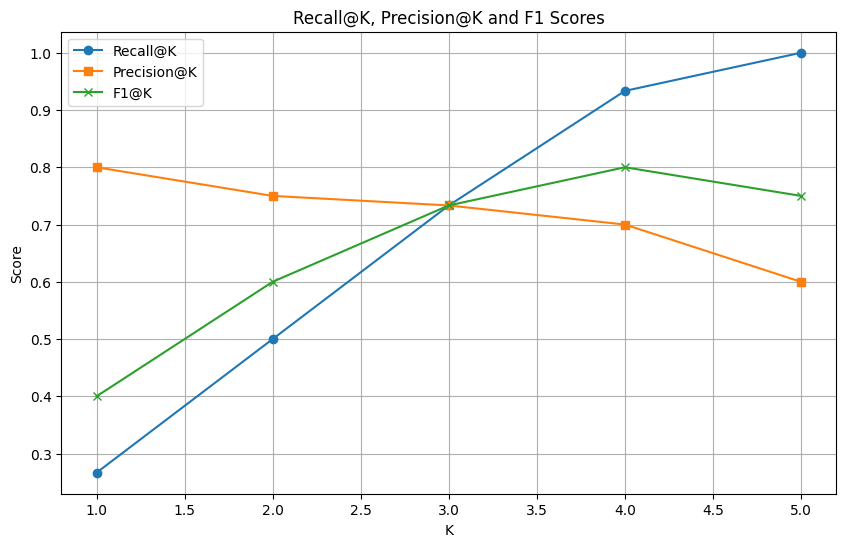

In [73]:
# Example predictions and ground truths
predictions = [
    [("cat", "on", "mat", 0.9), ("dog", "next to", "cat", 0.8), ("book", "on", "table", 0.7), ("person", "holds", "book", 0.6), ("apple", "on", "tree", 0.5)],
    [("car", "parked", "road", 0.8), ("tree", "near", "car", 0.5), ("man", "drives", "car", 0.4), ("woman", "walks", "dog", 0.6), ("bird", "flies", "sky", 0.7)],
    [("computer", "on", "desk", 0.6), ("phone", "on", "desk", 0.4), ("lamp", "near", "window", 0.5), ("person", "sits", "chair", 0.8), ("cup", "on", "table", 0.9)],
    [("dog", "chases", "cat", 0.7), ("bird", "in", "tree", 0.2), ("car", "stops", "road", 0.4), ("person", "reads", "book", 0.6), ("phone", "rings", "desk", 0.88)],
    [("man", "throws", "ball", 0.5), ("ball", "hits", "ground", 0.7), ("dog", "fetches", "ball", 0.6), ("tree", "grows", "forest", 0.8), ("cloud", "covers", "sun", 0.9)],
    [("bird", "flies", "sky", 0.95), ("cat", "on", "mat", 0.8), ("dog", "next to", "cat", 0.7), ("apple", "on", "tree", 0.65), ("person", "sits", "chair", 0.6)],
    [("person", "holds", "book", 0.92), ("cat", "on", "mat", 0.85), ("dog", "next to", "cat", 0.75), ("ball", "on", "floor", 0.5), ("apple", "on", "tree", 0.45)],
    [("cat", "on", "mat", 0.9), ("dog", "next to", "cat", 0.8), ("table", "under", "book", 0.6), ("apple", "on", "tree", 0.55), ("person", "reads", "book", 0.5)],
    [("book", "on", "table", 0.88), ("cat", "on", "mat", 0.7), ("dog", "next to", "cat", 0.6), ("apple", "on", "tree", 0.55), ("person", "holds", "book", 0.45)],
    [("dog", "next to", "cat", 0.9), ("cat", "on", "mat", 0.75), ("person", "sits", "chair", 0.7), ("apple", "on", "tree", 0.65), ("book", "on", "table", 0.6)]
]

ground_truths = [
    [("cat", "on", "mat"), ("dog", "next to", "cat"), ("book", "on", "table")],
    [("car", "parked", "road"), ("tree", "near", "car"), ("woman", "walks", "dog")],
    [("computer", "on", "desk"), ("lamp", "near", "window"), ("cup", "on", "table")],
    [("dog", "chases", "cat"), ("car", "stops", "road"), ("person", "reads", "book")],
    [("man", "throws", "ball"), ("dog", "fetches", "ball"), ("tree", "grows", "forest")],
    [("bird", "flies", "sky"), ("dog", "next to", "cat"), ("apple", "on", "tree")],
    [("person", "holds", "book"), ("cat", "on", "mat"), ("dog", "next to", "cat")],
    [("cat", "on", "mat"), ("dog", "next to", "cat"), ("apple", "on", "tree")],
    [("book", "on", "table"), ("cat", "on", "mat"), ("dog", "next to", "cat")],
    [("dog", "next to", "cat"), ("cat", "on", "mat"), ("book", "on", "table")]
]



k_values = list(range(1, 6))
recall_scores = []
precision_scores = []
f1_scores = []

for K in k_values:
    recall = recall_at_k(predictions, ground_truths, K)
    precision = precision_at_k(predictions, ground_truths, K)
    f1 = f1_score(recall, precision)
    
    recall_scores.append(recall)
    precision_scores.append(precision)
    f1_scores.append(f1)
    
plot_recall_precision(k_values, recall_scores, precision_scores, f1_scores)